# Final Capstone

In this project we will put ourselves in the shoes of an NFL defensive coordinator, specifically in the shoes of the defensive coordinator for the Buffalo Bills, an in-division rival. We're playing the New England Patriots at the end of the 2018 NFL season and we need to stop Tom Brady, Bill Belichick and the Patriots' offense. Instead of using 'gut feel' to guess what play the Patriots will run next (and what we need to be prepared for), we will use machine learning techniques to help us determine the most likely play type in any game situation. We'll begin by importing our data sets, the first of which is hosted on Kaggle and contains information about every play run in the NFL from 2009 through 2018. The second was compiled from NFL.com and contains information about every defense for the 2018 season.

In [1]:
# importing packages we'll need
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statistics as stat
%matplotlib inline
import warnings
from sklearn import preprocessing
from sklearn.preprocessing import normalize
warnings.filterwarnings('ignore')

In [2]:
# reading the data set
df = pd.read_csv('NFL_data.csv', low_memory=False)
# https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016/download

In [3]:
# reading the data set
defenses_df = pd.read_csv('defensive_data.csv', low_memory=False)
# http://www.nfl.com/stats/categorystats?seasonType=REG&offensiveStatisticCategory=null&d-447263-n=1&d-447263-o=1&d-447263-p=1&d-447263-s=RUSHING_YARDS_PER_GAME_AVG&tabSeq=2&season=2018&role=OPP&Submit=Go&archive=true&conference=null&defensiveStatisticCategory=RUSHING&qualified=false

In [4]:
df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,46,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
3,113,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
4,139,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


In [5]:
NE_df = df.loc[df['posteam'] == 'NE', ]

<br>New England has had the same head coach, offensive coordinator, and quarterback since the 2012 season, so we will remove the data before that season.<br>

In [6]:
NE_df['game_date'] = pd.to_datetime(NE_df['game_date'])

In [7]:
NE_df = NE_df.loc[NE_df['game_date'] > datetime.datetime(2012, 7, 1), ]

In [8]:
NE_df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
135504,360,2012090904,TEN,NE,NE,away,TEN,TEN,35.0,2012-09-09,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
135505,387,2012090904,TEN,NE,NE,away,TEN,NE,74.0,2012-09-09,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
135506,411,2012090904,TEN,NE,NE,away,TEN,NE,66.0,2012-09-09,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
135507,432,2012090904,TEN,NE,NE,away,TEN,NE,65.0,2012-09-09,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
135508,453,2012090904,TEN,NE,NE,away,TEN,TEN,48.0,2012-09-09,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


## Data Exploration

Now that we've got the data filtered down to plays run by our opponent under the current offensive staff, let's begin exploring the data. What information is contained in these 255 columns?

In [9]:
list(NE_df)

['play_id',
 'game_id',
 'home_team',
 'away_team',
 'posteam',
 'posteam_type',
 'defteam',
 'side_of_field',
 'yardline_100',
 'game_date',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'game_half',
 'quarter_end',
 'drive',
 'sp',
 'qtr',
 'down',
 'goal_to_go',
 'time',
 'yrdln',
 'ydstogo',
 'ydsnet',
 'desc',
 'play_type',
 'yards_gained',
 'shotgun',
 'no_huddle',
 'qb_dropback',
 'qb_kneel',
 'qb_spike',
 'qb_scramble',
 'pass_length',
 'pass_location',
 'air_yards',
 'yards_after_catch',
 'run_location',
 'run_gap',
 'field_goal_result',
 'kick_distance',
 'extra_point_result',
 'two_point_conv_result',
 'home_timeouts_remaining',
 'away_timeouts_remaining',
 'timeout',
 'timeout_team',
 'td_team',
 'posteam_timeouts_remaining',
 'defteam_timeouts_remaining',
 'total_home_score',
 'total_away_score',
 'posteam_score',
 'defteam_score',
 'score_differential',
 'posteam_score_post',
 'defteam_score_post',
 'score_differential_post',
 'no_sc

<br>Since we will be trying to guess play types as a defensive coordinator, let's take a look at the various play types defined in the data set.<br><br>

In [10]:
NE_df.play_type.unique()

array(['kickoff', 'pass', 'run', 'punt', 'extra_point', 'no_play',
       'qb_kneel', 'field_goal', 'qb_spike'], dtype=object)

<br> We're only interested in plays a defense might face, so we'll do some filtering. <br><br>

In [11]:
play_list = ['pass', 'run']
location_list = ['left', 'right', 'middle', 'NA']

In [12]:
NE_df = NE_df.loc[NE_df.play_type.isin(play_list), ]


<br> We've filtered down to only runs and passes, or plays a defense will be expected to defend. Now we need to define each play, according to whether it was a run or pass, whether it was to the left, right or middle, and whether the pass was deep or short. This will give us 9 play types.<br><br>

In [13]:
def get_full_play_type(play):
    play_type, pass_location, run_location, pass_length = play
    if(play_type == 'run'):
        return play_type+'_'+ run_location
    else:
        return pass_length +'_'+play_type+'_'+ pass_location
NE_df = NE_df.replace(np.nan, 'unknown', regex=True)  


NE_df['full_play_type'] = NE_df[['play_type','pass_location', 'run_location', 'pass_length']].apply(get_full_play_type, axis=1)


In [14]:
# getting rid of unknowns
play_filter = ['run_left', 'run_middle', 'run_right', 'short_pass_left', 'short_pass_middle', 'short_pass_right', 'deep_pass_left', 'deep_pass_middle', 'deep_pass_right']

In [15]:
#getting rid of unknowns
NE_df = NE_df.loc[NE_df.full_play_type.isin(play_filter), ]

In [16]:
NE_df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,full_play_type
135505,387,2012090904,TEN,NE,NE,away,TEN,NE,74.0,2012-09-09,...,unknown,unknown,0,unknown,unknown,0.0,0.0,0.0,0.0,short_pass_right
135506,411,2012090904,TEN,NE,NE,away,TEN,NE,66.0,2012-09-09,...,unknown,unknown,0,unknown,unknown,0.0,0.0,0.0,0.0,run_left
135507,432,2012090904,TEN,NE,NE,away,TEN,NE,65.0,2012-09-09,...,unknown,unknown,0,unknown,unknown,0.0,0.0,0.0,0.0,run_left
135508,453,2012090904,TEN,NE,NE,away,TEN,TEN,48.0,2012-09-09,...,unknown,unknown,0,unknown,unknown,0.0,0.0,0.0,0.0,deep_pass_left
135509,475,2012090904,TEN,NE,NE,away,TEN,TEN,48.0,2012-09-09,...,unknown,unknown,0,unknown,unknown,0.0,0.0,0.0,0.0,run_middle


<br> We've created a new column that defines each play according to our definitions, so now let's try to visualize the data!<br><br>

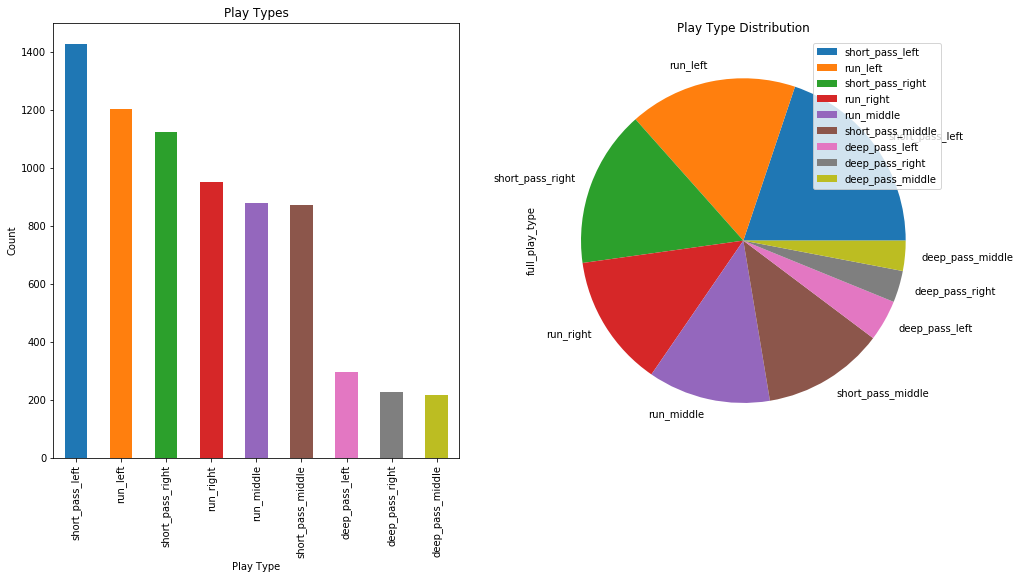

In [17]:
plt.figure(figsize=(16, 8)) #making a subplot

plt.subplot(1, 2, 1)
NE_df.full_play_type.value_counts().plot(kind='bar')
plt.title('Play Types')
plt.ylabel('Count')
plt.xlabel('Play Type')

plt.subplot(1, 2, 2)
NE_df.full_play_type.value_counts().plot(kind='pie')
plt.title('Play Type Distribution')
plt.legend()
plt.show()

We can tell right away that New England likes going left most, then right, and then over the middle. We can also clearly see that deep passes are the least likely play call.<br>

Let's take a look and see how this changes according to the down.<br><br>

In [18]:
NE_df.down.unique()

array([1.0, 2.0, 3.0, 4.0], dtype=object)

In [19]:
first_df = NE_df.loc[NE_df['down'] == 1.0, ]
second_df = NE_df.loc[NE_df['down'] == 2.0, ]
third_df = NE_df.loc[NE_df['down'] == 3.0, ]

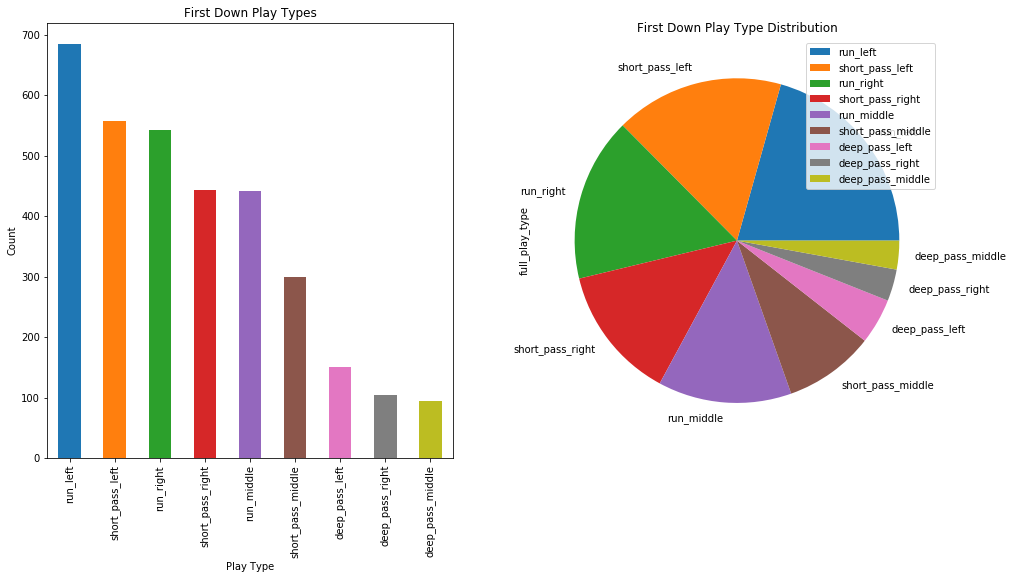

In [20]:
plt.figure(figsize=(16, 8)) #making a subplot

plt.subplot(1, 2, 1)
first_df.full_play_type.value_counts().plot(kind='bar')
plt.title('First Down Play Types')
plt.ylabel('Count')
plt.xlabel('Play Type')

plt.subplot(1, 2, 2)
first_df.full_play_type.value_counts().plot(kind='pie')
plt.title('First Down Play Type Distribution')
plt.legend()
plt.show()

<br>This distribution looks very much like the overall distribution, which makes sense. There will always be more first down plays than any other down.<br><br>

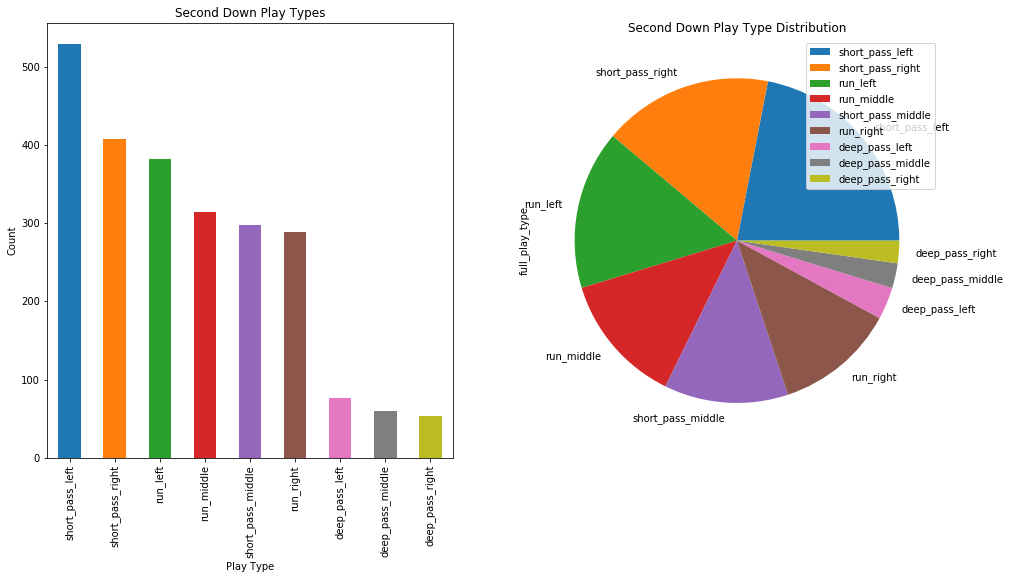

In [21]:
plt.figure(figsize=(16, 8)) #making a subplot

plt.subplot(1, 2, 1)
second_df.full_play_type.value_counts().plot(kind='bar')
plt.title('Second Down Play Types')
plt.ylabel('Count')
plt.xlabel('Play Type')

plt.subplot(1, 2, 2)
second_df.full_play_type.value_counts().plot(kind='pie')
plt.title('Second Down Play Type Distribution')
plt.legend()
plt.show()

<br><br> Here we see a difference that also makes sense. On second down passing has become more popular relative to running, and the Patriots still love to go left. <br><br>

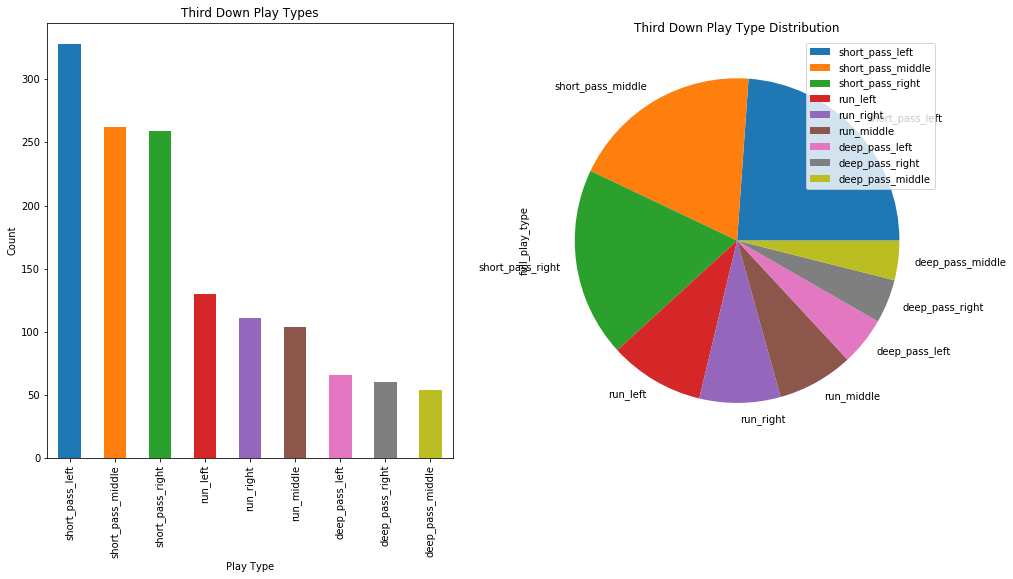

In [22]:
plt.figure(figsize=(16, 8)) #making a subplot

plt.subplot(1, 2, 1)
third_df.full_play_type.value_counts().plot(kind='bar')
plt.title('Third Down Play Types')
plt.ylabel('Count')
plt.xlabel('Play Type')

plt.subplot(1, 2, 2)
third_df.full_play_type.value_counts().plot(kind='pie')
plt.title('Third Down Play Type Distribution')
plt.legend()
plt.show()

Here we can see that passes dominate on third down, and that although all types of deep passes are still the least common play call, they are here much closer to the other play types. <br><br>

Next, let's take a look at how often runs and passes are called according to the yardage needed for a first down.

In [23]:
pass_df = NE_df.loc[NE_df['play_type'] == 'pass', ]
run_df = NE_df.loc[NE_df['play_type'] == 'run', ]

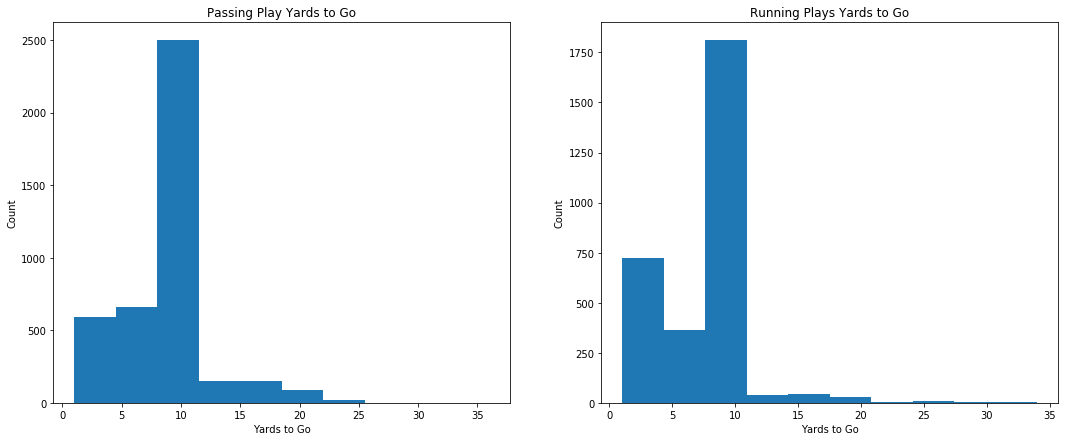

In [24]:
plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
plt.hist(pass_df.ydstogo)
plt.title('Passing Play Yards to Go')
plt.ylabel('Count')
plt.xlabel('Yards to Go')

plt.subplot(1, 2, 2)
plt.hist(run_df.ydstogo)
plt.title('Running Plays Yards to Go')
plt.ylabel('Count')
plt.xlabel('Yards to Go')
plt.show()

<br><br>
Here we see the effect of first and ten being the most common down. However, beyond that we see that passes are more likely in long yardage situations and runs are more likely in short yardage situations.<br><br>

Finally, let's take a look at the average yardage needed for each play type.<br><br>

Text(0.5, 0, 'Full Play Type')

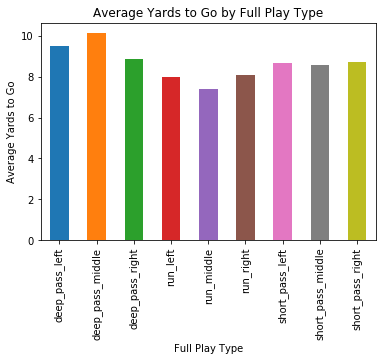

In [25]:

full_plays = NE_df.groupby('full_play_type') # grouping the data by full play type
full_plays.ydstogo.mean().plot(kind='bar')
plt.title('Average Yards to Go by Full Play Type')
plt.ylabel('Average Yards to Go')
plt.xlabel('Full Play Type')

<br><br>
Once again, this roughly matches up with what we would expect: deep passes are called when more yards are needed, short passes are called when intermediate yardage is needed, and runs are called when short yardage is needed.<br><br>

## K-Means Clustering- Unnormalized Data

As our next step, we will perform some clustering techniques to try to find defenses similar to ours. The idea is that New England might have similar play calling against similar defenses.<br><br>

In [26]:
defenses_df.head()

,Pass_Rk,Team,Pts/G,TotPts,TotYards,Comp,Att,Comp_Pct,Att/G,Pass_Yds,...,Run_Att/G,Rush_Yds,Rush_Avg,Rush_Yds/G,Rush_TD,Run_Lng,Run_1st%,Run_20+,Run_40+,FUM
0,4,Arizona Cardinals,26.6,425,5741.0,342,506,67.6,31.6,3262,...,31.9,2479,4.9,154.9,25,65,27.3,21,4,3
1,27,Atlanta Falcons,26.4,423,6152.0,398,585,68.0,36.6,4153,...,25.6,1999,4.9,124.9,16,92,28.1,13,1,10
2,5,Baltimore Ravens,17.9,287,4687.0,337,577,58.4,36.1,3360,...,22.1,1327,3.7,82.9,11,35,23.2,6,0,2
3,1,Buffalo Bills,23.4,374,4706.0,313,492,63.6,30.8,2867,...,27.5,1839,4.2,114.9,17,43,25.2,12,1,10
4,18,Carolina Panthers,23.9,382,5651.0,353,529,66.7,33.1,3847,...,24.0,1804,4.7,112.8,13,60,28.6,17,2,9


In [27]:
team_list = list(defenses_df['Team'])
defenses_df = defenses_df.drop('Team', 1)

In [28]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=4, random_state=42).fit(defenses_df)

km_labels = km.labels_

km_cluster_centers = km.cluster_centers_

In [29]:
defenses_df['cluster'] = km_labels
defenses_df['Team'] = team_list

In [30]:
defenses_df.head(32)

,Pass_Rk,Pts/G,TotPts,TotYards,Comp,Att,Comp_Pct,Att/G,Pass_Yds,Pass_Avg,...,Rush_Avg,Rush_Yds/G,Rush_TD,Run_Lng,Run_1st%,Run_20+,Run_40+,FUM,cluster,Team
0,4,26.6,425,5741.0,342,506,67.6,31.6,3262,7.1,...,4.9,154.9,25,65,27.3,21,4,3,2,Arizona Cardinals
1,27,26.4,423,6152.0,398,585,68.0,36.6,4153,7.5,...,4.9,124.9,16,92,28.1,13,1,10,3,Atlanta Falcons
2,5,17.9,287,4687.0,337,577,58.4,36.1,3360,6.3,...,3.7,82.9,11,35,23.2,6,0,2,0,Baltimore Ravens
3,1,23.4,374,4706.0,313,492,63.6,30.8,2867,6.3,...,4.2,114.9,17,43,25.2,12,1,10,0,Buffalo Bills
4,18,23.9,382,5651.0,353,529,66.7,33.1,3847,7.7,...,4.7,112.8,13,60,28.6,17,2,9,2,Carolina Panthers
5,7,17.7,283,4795.0,377,615,61.3,38.4,3515,6.3,...,3.8,80.0,5,32,19.8,7,0,5,0,Chicago Bears
6,32,28.4,455,6618.0,389,584,66.6,36.5,4414,7.9,...,4.7,137.8,17,65,26.8,15,2,3,3,Cincinnati Bengals
7,25,24.5,392,6288.0,393,626,62.8,39.1,4125,7.0,...,4.7,135.2,20,52,28.3,18,1,6,3,Cleveland Browns
8,13,20.2,324,5268.0,367,542,67.7,33.9,3755,7.4,...,3.8,94.6,12,68,22.3,9,1,7,2,Dallas Cowboys
9,20,21.8,349,5842.0,353,549,64.3,34.3,3929,7.7,...,4.5,119.6,11,77,19.8,15,5,6,2,Denver Broncos


In [31]:
defenses_df.cluster.value_counts()

2    15
3     9
0     5
1     3
Name: cluster, dtype: int64

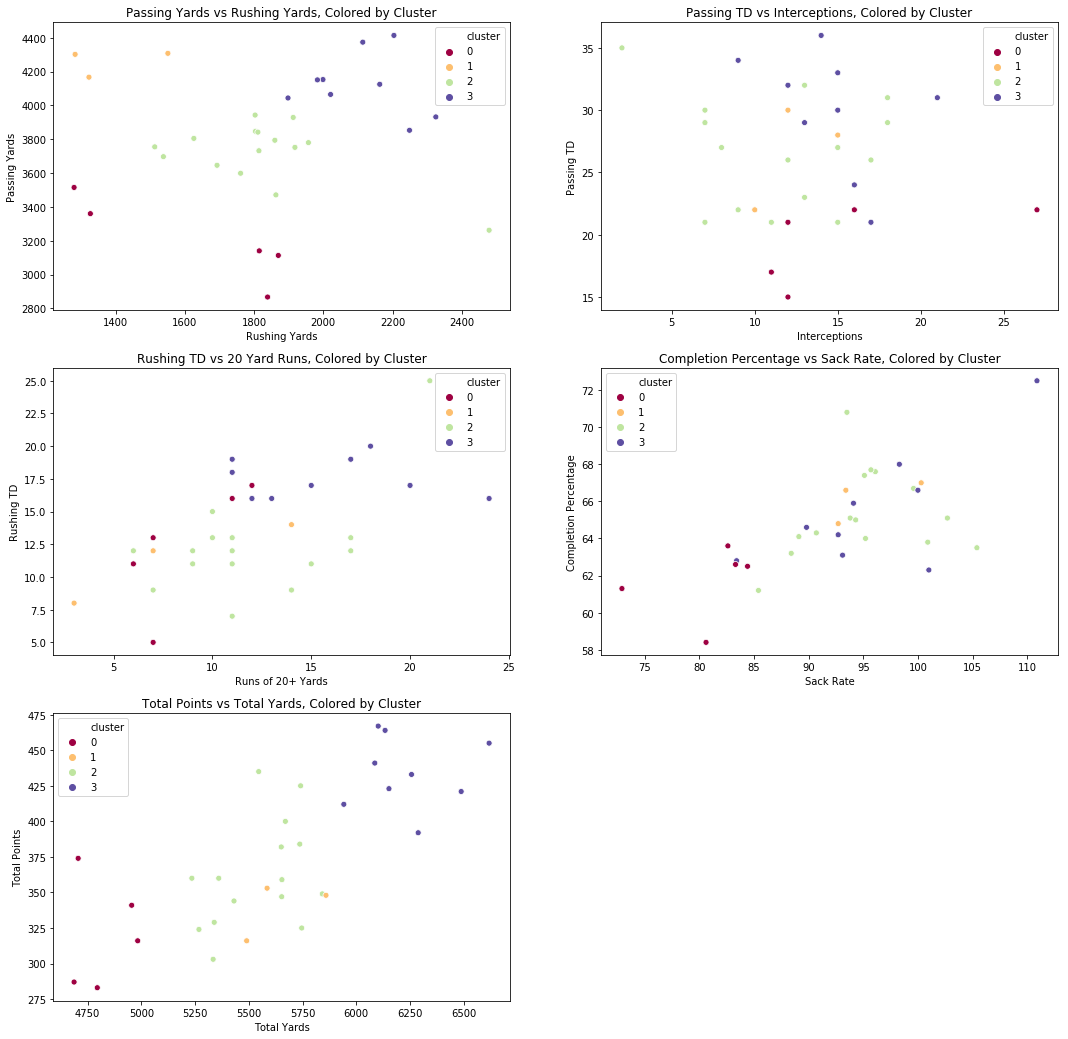

In [32]:
plt.figure(figsize=(18, 18)) #making a subplot

plt.subplot(3, 2, 1)
sns.scatterplot(y='Pass_Yds', x='Rush_Yds', hue='cluster', data=defenses_df, palette='Spectral')
plt.ylabel('Passing Yards')
plt.xlabel('Rushing Yards')
plt.title('Passing Yards vs Rushing Yards, Colored by Cluster')

plt.subplot(3, 2, 2)
sns.scatterplot(y='Pass_TD', x='Int', hue='cluster', data=defenses_df, palette='Spectral')
plt.ylabel('Passing TD')
plt.xlabel('Interceptions')
plt.title('Passing TD vs Interceptions, Colored by Cluster')

plt.subplot(3, 2, 3)
sns.scatterplot(y='Rush_TD', x='Run_20+', hue='cluster', data=defenses_df, palette='Spectral')
plt.ylabel('Rushing TD')
plt.xlabel('Runs of 20+ Yards')
plt.title('Rushing TD vs 20 Yard Runs, Colored by Cluster')

plt.subplot(3, 2, 4)
sns.scatterplot(y='Comp_Pct', x='Sck_Rate', hue='cluster', data=defenses_df, palette='Spectral')
plt.ylabel('Completion Percentage')
plt.xlabel('Sack Rate')
plt.title('Completion Percentage vs Sack Rate, Colored by Cluster')

plt.subplot(3, 2, 5)
sns.scatterplot(y='TotPts', x='TotYards', hue='cluster', data=defenses_df, palette='Spectral')
plt.ylabel('Total Points')
plt.xlabel('Total Yards')
plt.title('Total Points vs Total Yards, Colored by Cluster')
plt.show()

Our defense (Buffalo) belongs to cluster 0, along with Baltimore, Chicago, Jacksonville, and Minnesota. From the diagnostic plots it looks like cluster 0 is typified by low yards allowed (rushing, passing, and total) and to a lesser extent by allowing fewer points. Cluster 0 also seems to have a low sack rate, but limit completion percentage and runs of 20 or more yards.

## K-Means Clustering- Normalized Data

In [33]:
norm_def = defenses_df.copy()

In [34]:
norm_def.head()

,Pass_Rk,Pts/G,TotPts,TotYards,Comp,Att,Comp_Pct,Att/G,Pass_Yds,Pass_Avg,...,Rush_Avg,Rush_Yds/G,Rush_TD,Run_Lng,Run_1st%,Run_20+,Run_40+,FUM,cluster,Team
0,4,26.6,425,5741.0,342,506,67.6,31.6,3262,7.1,...,4.9,154.9,25,65,27.3,21,4,3,2,Arizona Cardinals
1,27,26.4,423,6152.0,398,585,68.0,36.6,4153,7.5,...,4.9,124.9,16,92,28.1,13,1,10,3,Atlanta Falcons
2,5,17.9,287,4687.0,337,577,58.4,36.1,3360,6.3,...,3.7,82.9,11,35,23.2,6,0,2,0,Baltimore Ravens
3,1,23.4,374,4706.0,313,492,63.6,30.8,2867,6.3,...,4.2,114.9,17,43,25.2,12,1,10,0,Buffalo Bills
4,18,23.9,382,5651.0,353,529,66.7,33.1,3847,7.7,...,4.7,112.8,13,60,28.6,17,2,9,2,Carolina Panthers


In [35]:
norm_def = norm_def.drop('Team', 1)
norm_def = norm_def.drop('cluster', 1)

In [36]:
norm_def=((norm_def-norm_def.min())/(norm_def.max()-norm_def.min()))

In [37]:
norm_def.head()

,Pass_Rk,Pts/G,TotPts,TotYards,Comp,Att,Comp_Pct,Att/G,Pass_Yds,Pass_Avg,...,Run_Att/G,Rush_Yds,Rush_Avg,Rush_Yds/G,Rush_TD,Run_Lng,Run_1st%,Run_20+,Run_40+,FUM
0,0.096774,0.773913,0.771739,0.545831,0.364407,0.171053,0.652482,0.168421,0.255333,0.421053,...,1.000000,1.000000,0.882353,1.000000,1.00,0.521127,0.710280,0.857143,0.571429,0.1
1,0.838710,0.756522,0.760870,0.758674,0.838983,0.690789,0.680851,0.694737,0.831286,0.631579,...,0.432432,0.599666,0.882353,0.599466,0.55,0.901408,0.785047,0.476190,0.142857,0.8
2,0.129032,0.017391,0.021739,0.000000,0.322034,0.638158,0.000000,0.642105,0.318681,0.000000,...,0.117117,0.039199,0.176471,0.038718,0.30,0.098592,0.327103,0.142857,0.000000,0.0
3,0.000000,0.495652,0.494565,0.009839,0.118644,0.078947,0.368794,0.084211,0.000000,0.000000,...,0.603604,0.466222,0.470588,0.465955,0.60,0.211268,0.514019,0.428571,0.142857,0.8
4,0.548387,0.539130,0.538043,0.499223,0.457627,0.322368,0.588652,0.326316,0.633484,0.736842,...,0.288288,0.437031,0.764706,0.437917,0.40,0.450704,0.831776,0.666667,0.285714,0.7


In [38]:
km2 = KMeans(n_clusters=4, random_state=42).fit(norm_def)

km2_labels = km2.labels_

km2_cluster_centers = km2.cluster_centers_

In [39]:
norm_def['cluster'] = km2_labels
norm_def['Team'] = team_list

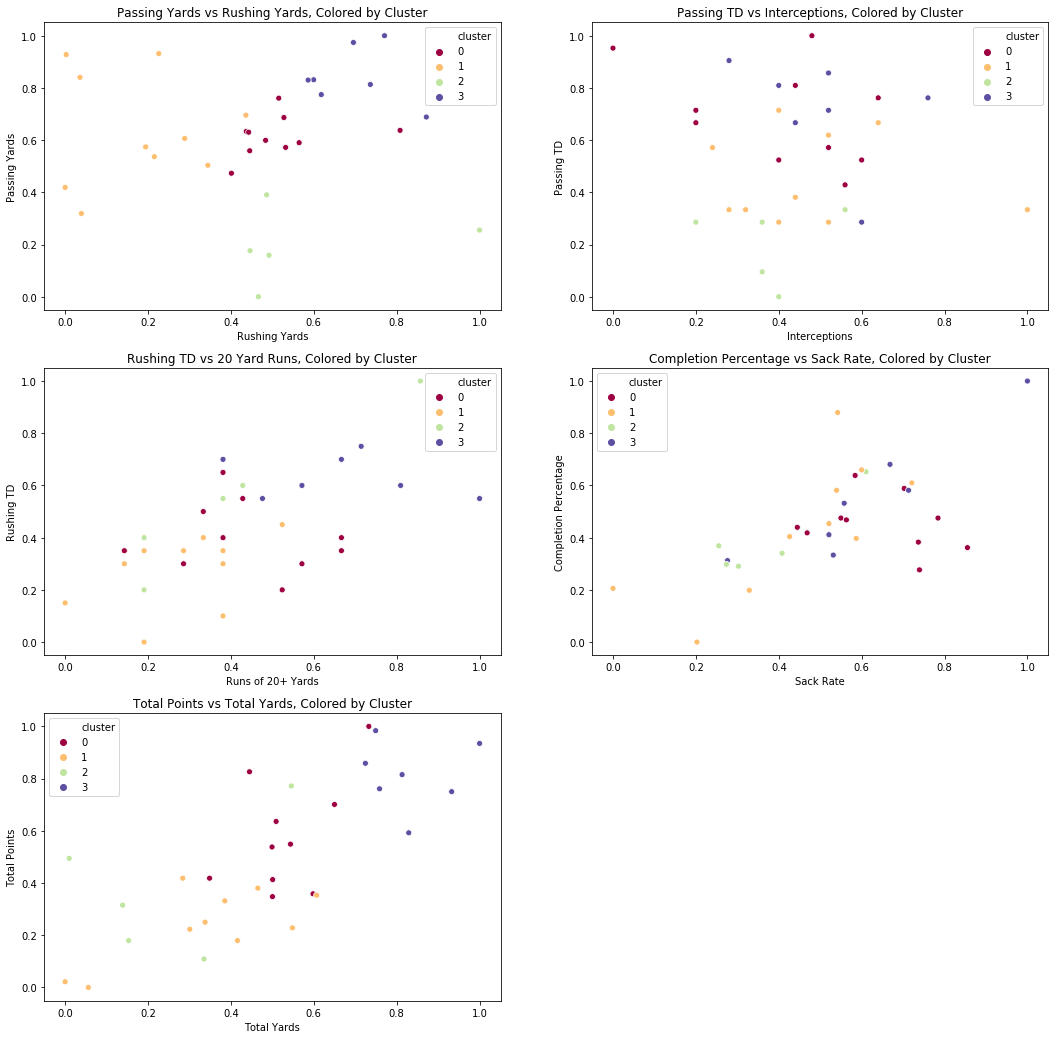

In [40]:
plt.figure(figsize=(18, 18)) #making a subplot

plt.subplot(3, 2, 1)
sns.scatterplot(y='Pass_Yds', x='Rush_Yds', hue='cluster', data=norm_def, palette='Spectral')
plt.ylabel('Passing Yards')
plt.xlabel('Rushing Yards')
plt.title('Passing Yards vs Rushing Yards, Colored by Cluster')

plt.subplot(3, 2, 2)
sns.scatterplot(y='Pass_TD', x='Int', hue='cluster', data=norm_def, palette='Spectral')
plt.ylabel('Passing TD')
plt.xlabel('Interceptions')
plt.title('Passing TD vs Interceptions, Colored by Cluster')

plt.subplot(3, 2, 3)
sns.scatterplot(y='Rush_TD', x='Run_20+', hue='cluster', data=norm_def, palette='Spectral')
plt.ylabel('Rushing TD')
plt.xlabel('Runs of 20+ Yards')
plt.title('Rushing TD vs 20 Yard Runs, Colored by Cluster')

plt.subplot(3, 2, 4)
sns.scatterplot(y='Comp_Pct', x='Sck_Rate', hue='cluster', data=norm_def, palette='Spectral')
plt.ylabel('Completion Percentage')
plt.xlabel('Sack Rate')
plt.title('Completion Percentage vs Sack Rate, Colored by Cluster')

plt.subplot(3, 2, 5)
sns.scatterplot(y='TotPts', x='TotYards', hue='cluster', data=norm_def, palette='Spectral')
plt.ylabel('Total Points')
plt.xlabel('Total Yards')
plt.title('Total Points vs Total Yards, Colored by Cluster')
plt.show()

In [41]:
norm_def.head(32)

,Pass_Rk,Pts/G,TotPts,TotYards,Comp,Att,Comp_Pct,Att/G,Pass_Yds,Pass_Avg,...,Rush_Avg,Rush_Yds/G,Rush_TD,Run_Lng,Run_1st%,Run_20+,Run_40+,FUM,cluster,Team
0,0.096774,0.773913,0.771739,0.545831,0.364407,0.171053,0.652482,0.168421,0.255333,0.421053,...,0.882353,1.000000,1.00,0.521127,0.710280,0.857143,0.571429,0.1,2,Arizona Cardinals
1,0.838710,0.756522,0.760870,0.758674,0.838983,0.690789,0.680851,0.694737,0.831286,0.631579,...,0.882353,0.599466,0.55,0.901408,0.785047,0.476190,0.142857,0.8,3,Atlanta Falcons
2,0.129032,0.017391,0.021739,0.000000,0.322034,0.638158,0.000000,0.642105,0.318681,0.000000,...,0.176471,0.038718,0.30,0.098592,0.327103,0.142857,0.000000,0.0,1,Baltimore Ravens
3,0.000000,0.495652,0.494565,0.009839,0.118644,0.078947,0.368794,0.084211,0.000000,0.000000,...,0.470588,0.465955,0.60,0.211268,0.514019,0.428571,0.142857,0.8,2,Buffalo Bills
4,0.548387,0.539130,0.538043,0.499223,0.457627,0.322368,0.588652,0.326316,0.633484,0.736842,...,0.764706,0.437917,0.40,0.450704,0.831776,0.666667,0.285714,0.7,0,Carolina Panthers
5,0.193548,0.000000,0.000000,0.055930,0.661017,0.888158,0.205674,0.884211,0.418875,0.000000,...,0.235294,0.000000,0.00,0.056338,0.009346,0.190476,0.000000,0.3,1,Chicago Bears
6,1.000000,0.930435,0.934783,1.000000,0.762712,0.684211,0.581560,0.684211,1.000000,0.842105,...,0.764706,0.771696,0.60,0.521127,0.663551,0.571429,0.285714,0.1,3,Cincinnati Bengals
7,0.774194,0.591304,0.592391,0.829104,0.796610,0.960526,0.312057,0.957895,0.813187,0.368421,...,0.764706,0.736983,0.75,0.338028,0.803738,0.714286,0.142857,0.4,3,Cleveland Browns
8,0.387097,0.217391,0.222826,0.300880,0.576271,0.407895,0.659574,0.410526,0.574014,0.578947,...,0.235294,0.194927,0.35,0.563380,0.242991,0.285714,0.142857,0.5,1,Dallas Cowboys
9,0.612903,0.356522,0.358696,0.598136,0.457627,0.453947,0.418440,0.452632,0.686490,0.736842,...,0.647059,0.528705,0.30,0.690141,0.009346,0.571429,0.714286,0.4,0,Denver Broncos


In this iteration Buffalo falls into cluster 2, along with Arizona, Jacksonville, Minnesota, and Tennessee. Cluster 2 is made up of defenses that are better than average against the pass and roughly average against the run. For example, cluster 2 is approximately average in interceptions but is the best against allowing TD passes.

## Mean Shift Normalized Data

In [42]:
norm_def = norm_def.drop('cluster', 1)
norm_def = norm_def.drop('Team', 1)

In [43]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
my_bandwidth = estimate_bandwidth(norm_def)
my_bandwidth

1.5586399521308762

In [44]:
# Declare and fit the model.
ms = MeanShift(bandwidth=10000000, bin_seeding=True)
ms.fit(norm_def)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 1


I wanted to try one more clustering technique, Mean Shift. I first used SK Learn's bandwidth estimator as an input into the algorithm, but this led to an estimation of only 1 cluster. I continued to adjust the bandwidth all the way up to 10,000,000 and still the algorithm only finds 1 cluster in the data. From here I concluded that this data set is not well-suited to Mean Shift clustering, and chose to move one to filtering and data cleaning.

## Initial Filtering and Data Cleaning

The goal of this project is to produce and tune 12 different models to estimate play calls by the New England offense. Each model will be either a Random Forest or Naive Bayes classifier, each model will accept as input either raw or normalized data, and each model will be trained on one of three data sets: All NE plays from 2012-2018, all NE plays in 2018, and NE plays in 2018 facing a defense in the same cluster as Buffalo.

In [45]:

#making copies we will use for other models later
NE2018_df = NE_df.copy()
cluster_df = NE_df.copy()

In [46]:
list(NE_df)

['play_id',
 'game_id',
 'home_team',
 'away_team',
 'posteam',
 'posteam_type',
 'defteam',
 'side_of_field',
 'yardline_100',
 'game_date',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'game_half',
 'quarter_end',
 'drive',
 'sp',
 'qtr',
 'down',
 'goal_to_go',
 'time',
 'yrdln',
 'ydstogo',
 'ydsnet',
 'desc',
 'play_type',
 'yards_gained',
 'shotgun',
 'no_huddle',
 'qb_dropback',
 'qb_kneel',
 'qb_spike',
 'qb_scramble',
 'pass_length',
 'pass_location',
 'air_yards',
 'yards_after_catch',
 'run_location',
 'run_gap',
 'field_goal_result',
 'kick_distance',
 'extra_point_result',
 'two_point_conv_result',
 'home_timeouts_remaining',
 'away_timeouts_remaining',
 'timeout',
 'timeout_team',
 'td_team',
 'posteam_timeouts_remaining',
 'defteam_timeouts_remaining',
 'total_home_score',
 'total_away_score',
 'posteam_score',
 'defteam_score',
 'score_differential',
 'posteam_score_post',
 'defteam_score_post',
 'score_differential_post',
 'no_sc

In [47]:
feat_list = ['play_id', 'game_id', 'posteam_type', 'defteam', 'yardline_100', 'game_seconds_remaining', 'down', 'goal_to_go', 'ydstogo', 'shotgun', 'no_huddle', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'posteam_score', 'defteam_score', 'full_play_type']

<br><br>This feature list is meant to incorporate all data in this set that would be available to a defensive coordinator before the snap.<br><br>

In [48]:
NE_df = NE_df.filter(items=feat_list)
NE_df.head()

,play_id,game_id,posteam_type,defteam,yardline_100,game_seconds_remaining,down,goal_to_go,ydstogo,shotgun,no_huddle,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,full_play_type
135505,387,2012090904,away,TEN,74.0,3217.0,1,0.0,10,0,0,3.0,3.0,0.0,3.0,short_pass_right
135506,411,2012090904,away,TEN,66.0,3182.0,2,0.0,2,0,0,3.0,3.0,0.0,3.0,run_left
135507,432,2012090904,away,TEN,65.0,3163.0,3,0.0,1,0,1,3.0,3.0,0.0,3.0,run_left
135508,453,2012090904,away,TEN,48.0,3140.0,1,0.0,10,0,1,3.0,3.0,0.0,3.0,deep_pass_left
135509,475,2012090904,away,TEN,48.0,3133.0,2,0.0,10,0,0,3.0,3.0,0.0,3.0,run_middle


In [49]:
#utilizing one hot encoding to convert string data to numeric
NE_df = pd.concat([NE_df, pd.get_dummies(NE_df['posteam_type'], drop_first=True)], axis=1)


In [50]:
NE_df = NE_df.drop('posteam_type', 1)
NE_df = NE_df.drop('defteam', 1)

In [51]:
NE_df.head()

,play_id,game_id,yardline_100,game_seconds_remaining,down,goal_to_go,ydstogo,shotgun,no_huddle,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,full_play_type,home
135505,387,2012090904,74.0,3217.0,1,0.0,10,0,0,3.0,3.0,0.0,3.0,short_pass_right,0
135506,411,2012090904,66.0,3182.0,2,0.0,2,0,0,3.0,3.0,0.0,3.0,run_left,0
135507,432,2012090904,65.0,3163.0,3,0.0,1,0,1,3.0,3.0,0.0,3.0,run_left,0
135508,453,2012090904,48.0,3140.0,1,0.0,10,0,1,3.0,3.0,0.0,3.0,deep_pass_left,0
135509,475,2012090904,48.0,3133.0,2,0.0,10,0,0,3.0,3.0,0.0,3.0,run_middle,0


<br><br>Next, let's check to see if any null values have made it this far.<br><br>

In [52]:
NE_df.shape

(7195, 15)

In [53]:
NE_df = NE_df.dropna()

In [54]:
NE_df.shape

(7195, 15)

<br><br> There are no null values in the set. Now let's see if there's anything else that needs to be converted into a numeric value. <br><br>

In [55]:
NE_df.select_dtypes(include=['object'])

,down,full_play_type
135505,1,short_pass_right
135506,2,run_left
135507,3,run_left
135508,1,deep_pass_left
135509,2,run_middle
135510,3,deep_pass_middle
135516,1,run_right
135517,2,short_pass_left
135518,1,run_left
135519,1,run_left


<br><br>Although the 'down' column appears to be numeric, it is currently a string, so we will have to convert it.<br><br>

In [56]:
NE_df = NE_df.loc[NE_df['down'] != 'unknown', ]

In [57]:
NE_df['down'] = NE_df['down'].astype(int)

In [58]:
NE_df.select_dtypes(include=['object'])

,full_play_type
135505,short_pass_right
135506,run_left
135507,run_left
135508,deep_pass_left
135509,run_middle
135510,deep_pass_middle
135516,run_right
135517,short_pass_left
135518,run_left
135519,run_left


In [59]:
NE_df.shape

(7195, 15)

<br><br>We've got all columns (except for the target) converted to numeric values. As a last step we will combine the offensive and defensive team score columns into a single differential score column and then our data will be ready to feed into models.<br><br>

In [60]:
NE_df['NE_lead'] = NE_df['posteam_score'] - NE_df['defteam_score']
NE_df = NE_df.drop('posteam_score', 1)
NE_df = NE_df.drop('defteam_score', 1)
NE_df.head()

,play_id,game_id,yardline_100,game_seconds_remaining,down,goal_to_go,ydstogo,shotgun,no_huddle,posteam_timeouts_remaining,defteam_timeouts_remaining,full_play_type,home,NE_lead
135505,387,2012090904,74.0,3217.0,1,0.0,10,0,0,3.0,3.0,short_pass_right,0,-3.0
135506,411,2012090904,66.0,3182.0,2,0.0,2,0,0,3.0,3.0,run_left,0,-3.0
135507,432,2012090904,65.0,3163.0,3,0.0,1,0,1,3.0,3.0,run_left,0,-3.0
135508,453,2012090904,48.0,3140.0,1,0.0,10,0,1,3.0,3.0,deep_pass_left,0,-3.0
135509,475,2012090904,48.0,3133.0,2,0.0,10,0,0,3.0,3.0,run_middle,0,-3.0


## Random Forest, Normalized- All NE Plays 2012-2018

In [61]:
norm_NE_df = NE_df.copy()

In [62]:
game_list = list(NE_df['game_id'])
play_list = list(NE_df['play_id'])
full_play_list = list(NE_df['full_play_type'])

In [63]:
norm_NE_df = norm_NE_df.drop('game_id', 1)
norm_NE_df = norm_NE_df.drop('play_id', 1)
norm_NE_df = norm_NE_df.drop('full_play_type', 1)

In [64]:
norm_NE_df=((norm_NE_df-norm_NE_df.min())/(norm_NE_df.max()-norm_NE_df.min()))

In [65]:
norm_NE_df.head()

,yardline_100,game_seconds_remaining,down,goal_to_go,ydstogo,shotgun,no_huddle,posteam_timeouts_remaining,defteam_timeouts_remaining,home,NE_lead
135505,0.744898,0.893522,0.000000,0.0,0.257143,0.0,0.0,1.0,1.0,0.0,0.422535
135506,0.663265,0.883792,0.333333,0.0,0.028571,0.0,0.0,1.0,1.0,0.0,0.422535
135507,0.653061,0.878510,0.666667,0.0,0.000000,0.0,1.0,1.0,1.0,0.0,0.422535
135508,0.479592,0.872116,0.000000,0.0,0.257143,0.0,1.0,1.0,1.0,0.0,0.422535
135509,0.479592,0.870170,0.333333,0.0,0.257143,0.0,0.0,1.0,1.0,0.0,0.422535


In [66]:
norm_NE_df['full_play_type'] = full_play_list

In [67]:
norm_NE_df.head()

,yardline_100,game_seconds_remaining,down,goal_to_go,ydstogo,shotgun,no_huddle,posteam_timeouts_remaining,defteam_timeouts_remaining,home,NE_lead,full_play_type
135505,0.744898,0.893522,0.000000,0.0,0.257143,0.0,0.0,1.0,1.0,0.0,0.422535,short_pass_right
135506,0.663265,0.883792,0.333333,0.0,0.028571,0.0,0.0,1.0,1.0,0.0,0.422535,run_left
135507,0.653061,0.878510,0.666667,0.0,0.000000,0.0,1.0,1.0,1.0,0.0,0.422535,run_left
135508,0.479592,0.872116,0.000000,0.0,0.257143,0.0,1.0,1.0,1.0,0.0,0.422535,deep_pass_left
135509,0.479592,0.870170,0.333333,0.0,0.257143,0.0,0.0,1.0,1.0,0.0,0.422535,run_middle


In [68]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier(n_estimators = 5, max_depth = 9, max_leaf_nodes = 9, random_state = 42)
X = norm_NE_df.drop('full_play_type', 1)
Y = norm_NE_df['full_play_type']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

temp = cross_val_score(rfc, X, Y, cv=10)
print(temp)
print(stat.mean(temp))
print(max(temp) - min(temp))

[0.27624309 0.29322268 0.26592798 0.27877947 0.3037448  0.2906815
 0.25348189 0.29567643 0.27412587 0.27692308]
0.2808806803724067
0.050262904740012104


Our first model has an average accuracy across the 10-fold cross validation of 28.1%, with a tight range from min to max of 5.03%. Also, the tuning of parameters led to an increase of the average accuracy of almost 7% compared to the default RFC parameters.

## Naive Bayes, Normalized- All NE Plays 2012-2018

In [69]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
X = norm_NE_df.drop('full_play_type', 1)
Y = norm_NE_df['full_play_type']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

temp = cross_val_score(bnb, X, Y, cv=10)
print(temp)
print(stat.mean(temp))
print(max(temp) - min(temp))

[0.27762431 0.29460581 0.27977839 0.28432732 0.29542302 0.29763561
 0.26880223 0.29567643 0.28111888 0.27972028]
0.28547122824393484
0.028833376594697868


Our first Naive Bayes classifier has an average accuracy across the 10-fold cross validation of 28.5%, with a very tight range from min to max of 2.9%. Tuning had no positive effect on this model. 

## Random Forest, Unnormalized- All NE Plays 2012-2018

In [70]:
NE_df = NE_df.drop('game_id', 1)
NE_df = NE_df.drop('play_id', 1)

In [71]:
NE_df.head()

,yardline_100,game_seconds_remaining,down,goal_to_go,ydstogo,shotgun,no_huddle,posteam_timeouts_remaining,defteam_timeouts_remaining,full_play_type,home,NE_lead
135505,74.0,3217.0,1,0.0,10,0,0,3.0,3.0,short_pass_right,0,-3.0
135506,66.0,3182.0,2,0.0,2,0,0,3.0,3.0,run_left,0,-3.0
135507,65.0,3163.0,3,0.0,1,0,1,3.0,3.0,run_left,0,-3.0
135508,48.0,3140.0,1,0.0,10,0,1,3.0,3.0,deep_pass_left,0,-3.0
135509,48.0,3133.0,2,0.0,10,0,0,3.0,3.0,run_middle,0,-3.0


In [72]:
rfc2 = ensemble.RandomForestClassifier(n_estimators = 5, max_depth = 9, max_leaf_nodes = 9, random_state = 42)
X = NE_df.drop('full_play_type', 1)
Y = NE_df['full_play_type']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

temp = cross_val_score(rfc2, X, Y, cv=10)
print(temp)
print(stat.mean(temp))
print(max(temp) - min(temp))

[0.27624309 0.29322268 0.26592798 0.27877947 0.3037448  0.2906815
 0.25348189 0.29567643 0.27412587 0.27692308]
0.2808806803724067
0.050262904740012104


Our second RFC model has an average accuracy across the 10-fold cross validation of 28.1%, with a tight range from min to max of 5.03%. Also, the tuning of parameters led to an increase of the average accuracy of 6.3% compared to the default RFC parameters.

## Naive Bayes, Unnormalized- All NE Plays 2012-2018

In [73]:
bnb2 = BernoulliNB()
X = NE_df.drop('full_play_type', 1)
Y = NE_df['full_play_type']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

temp = cross_val_score(bnb2, X, Y, cv=10)
print(temp)
print(stat.mean(temp))
print(max(temp) - min(temp))

[0.27762431 0.29183956 0.26869806 0.28987517 0.29958391 0.2906815
 0.26462396 0.28730823 0.27692308 0.26573427]
0.2812892041244684
0.03495995580264177


Our second Naive Bayes classifier has an average accuracy across the 10-fold cross validation of 28.1%, with a very tight range from min to max of 3.5%. I was not able to improve either output by tuning this model.

## Random Forest, Unnormalized- All NE Plays 2018

In [74]:
NE2018_df = NE2018_df.loc[NE2018_df['game_date'] > datetime.datetime(2018, 7, 1), ]

In [75]:
NE2018_df = NE2018_df.filter(items=feat_list)
NE2018_df = pd.concat([NE2018_df, pd.get_dummies(NE2018_df['posteam_type'], drop_first=True)], axis=1)
NE2018_df = NE2018_df.drop('posteam_type', 1)
NE2018_df = NE2018_df.drop('defteam', 1)
NE2018_df = NE2018_df.loc[NE2018_df['down'] != 'unknown', ]
NE2018_df['down'] = NE2018_df['down'].astype(int)
NE2018_df['NE_lead'] = NE2018_df['posteam_score'] - NE2018_df['defteam_score']
NE2018_df = NE2018_df.drop('posteam_score', 1)
NE2018_df = NE2018_df.drop('defteam_score', 1)
NE2018_df = NE2018_df.drop('game_id', 1)
NE2018_df = NE2018_df.drop('play_id', 1)
NE2018_df.head()

,yardline_100,game_seconds_remaining,down,goal_to_go,ydstogo,shotgun,no_huddle,posteam_timeouts_remaining,defteam_timeouts_remaining,full_play_type,home,NE_lead
408079,75.0,3600.0,1,0.0,10,0,0,3.0,3.0,run_middle,1,0.0
408080,69.0,3565.0,2,0.0,4,1,0,3.0,3.0,run_middle,1,0.0
408081,68.0,3529.0,3,0.0,3,1,0,3.0,3.0,run_middle,1,0.0
408084,19.0,3478.0,1,0.0,10,1,0,3.0,3.0,deep_pass_right,1,0.0
408085,19.0,3474.0,2,0.0,10,0,0,3.0,3.0,run_left,1,0.0


In [76]:
rfc3 = ensemble.RandomForestClassifier(random_state = 42)
X = NE2018_df.drop('full_play_type', 1)
Y = NE2018_df['full_play_type']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

temp = cross_val_score(rfc3, X, Y, cv=10)
print(temp)
print(stat.mean(temp))
print(max(temp) - min(temp))

[0.23762376 0.2        0.32       0.18367347 0.1875     0.44680851
 0.52688172 0.34408602 0.19565217 0.17391304]
0.2816138701729079
0.35296867695184664


The third RFC model has an average accuracy across the 10-fold cross validation of 28.2% with a very large range between min and max of 35.3%. This bears out my intuition about using only one season of data versus the earlier models which used 7 seasons of data: single season data is more relevant but has far fewer data points, which can lead to overfitting and a less stable model that is exposed by the large range of cross validation scores.

## Naive Bayes, Unnormalized- All NE Plays 2018

In [77]:
bnb3 = BernoulliNB(alpha = 1.5)
X = NE2018_df.drop('full_play_type', 1)
Y = NE2018_df['full_play_type']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

temp = cross_val_score(bnb3, X, Y, cv=10)
print(temp)
print(stat.mean(temp))
print(max(temp) - min(temp))

[0.25742574 0.25       0.27       0.2244898  0.22916667 0.36170213
 0.27956989 0.1827957  0.27173913 0.2173913 ]
0.2544280358999324
0.1789064287348433


Our third Naive Bayes classifier has an average accuracy across the 10-fold cross validation of 25.4%, with a range from min to max of 17.9%. Tuning this model improved the average accuracy by 0.11% and had no impact on the range of accuracies. 

## Random Forest, Normalized- All NE Plays 2018

In [78]:
norm_NE2018_df = NE2018_df.copy()

In [79]:
full_play_list = list(NE2018_df['full_play_type'])
norm_NE2018_df = norm_NE2018_df.drop('full_play_type', 1)

In [80]:
norm_NE2018_df=((norm_NE2018_df-norm_NE2018_df.min())/(norm_NE2018_df.max()-norm_NE2018_df.min()))

In [81]:
norm_NE2018_df['full_play_type'] = full_play_list
norm_NE2018_df.head()

,yardline_100,game_seconds_remaining,down,goal_to_go,ydstogo,shotgun,no_huddle,posteam_timeouts_remaining,defteam_timeouts_remaining,home,NE_lead,full_play_type
408079,0.762887,1.000000,0.000000,0.0,0.473684,0.0,0.0,1.0,1.0,1.0,0.387097,run_middle
408080,0.701031,0.990232,0.333333,0.0,0.157895,1.0,0.0,1.0,1.0,1.0,0.387097,run_middle
408081,0.690722,0.980184,0.666667,0.0,0.105263,1.0,0.0,1.0,1.0,1.0,0.387097,run_middle
408084,0.185567,0.965950,0.000000,0.0,0.473684,1.0,0.0,1.0,1.0,1.0,0.387097,deep_pass_right
408085,0.185567,0.964834,0.333333,0.0,0.473684,0.0,0.0,1.0,1.0,1.0,0.387097,run_left


In [82]:
rfc4 = ensemble.RandomForestClassifier(random_state = 42)
X = norm_NE2018_df.drop('full_play_type', 1)
Y = norm_NE2018_df['full_play_type']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

temp = cross_val_score(rfc4, X, Y, cv=10)
print(temp)
print(stat.mean(temp))
print(max(temp) - min(temp))

[0.23762376 0.2        0.32       0.18367347 0.1875     0.43617021
 0.52688172 0.34408602 0.17391304 0.17391304]
0.2783761273421956
0.35296867695184664


The fourth RFC model has an average accuracy across the 10-fold cross validation of 27.8% with a very large range between min and max of 35.3%. This bears out my intuition about using only one season of data versus the earlier models which used 7 seasons of data: single season data is more relevant but has far fewer data points, which can lead to overfitting and a less stable model that is exposed by the large range of cross validation scores.

## Naive Bayes, Normalized- All NE Plays 2018

In [83]:
bnb4 = BernoulliNB(alpha=1.8)
X = norm_NE2018_df.drop('full_play_type', 1)
Y = norm_NE2018_df['full_play_type']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

temp = cross_val_score(bnb4, X, Y, cv=10)
print(temp)
print(stat.mean(temp))
print(max(temp) - min(temp))

[0.25742574 0.23       0.28       0.24489796 0.22916667 0.22340426
 0.20430108 0.21505376 0.29347826 0.25      ]
0.2427727723322989
0.08917718560074803


Our fourth Naive Bayes classifier has an average accuracy across the 10-fold cross validation of 24.3%, with a range from min to max of 8.9%. Tuning this model improved the average accuracy by 0.52% and cut down on the range of accuracies from 9.6% to 8.9%. 

## Random Forest, Unnormalized- 2018 Versus Cluster Mates

In [84]:
cluster_df = cluster_df.loc[cluster_df['game_date'] > datetime.datetime(2018, 7, 1), ]

In [85]:
cluster_df.defteam.unique()

array(['HOU', 'JAX', 'DET', 'MIA', 'IND', 'KC', 'CHI', 'BUF', 'GB', 'TEN',
       'NYJ', 'MIN', 'PIT'], dtype=object)

In [86]:
clustermates = ['JAX', 'BUF', 'CHI', 'MIN']

In [87]:
cluster_df = cluster_df.loc[cluster_df.defteam.isin(clustermates), ]

In [88]:
cluster_df = cluster_df.filter(items=feat_list)
cluster_df = pd.concat([cluster_df, pd.get_dummies(cluster_df['posteam_type'], drop_first=True)], axis=1)
cluster_df = cluster_df.drop('posteam_type', 1)
cluster_df = cluster_df.drop('defteam', 1)
cluster_df = cluster_df.loc[cluster_df['down'] != 'unknown', ]
cluster_df['down'] = cluster_df['down'].astype(int)
cluster_df['NE_lead'] = cluster_df['posteam_score'] - cluster_df['defteam_score']
cluster_df = cluster_df.drop('posteam_score', 1)
cluster_df = cluster_df.drop('defteam_score', 1)
cluster_df = cluster_df.drop('game_id', 1)
cluster_df = cluster_df.drop('play_id', 1)
cluster_df.head()

,yardline_100,game_seconds_remaining,down,goal_to_go,ydstogo,shotgun,no_huddle,posteam_timeouts_remaining,defteam_timeouts_remaining,full_play_type,home,NE_lead
412460,75.0,3600.0,1,0.0,10,1,0,3.0,3.0,short_pass_right,0,0.0
412461,66.0,3566.0,2,0.0,1,0,0,3.0,3.0,run_middle,0,0.0
412462,64.0,3531.0,1,0.0,10,0,0,3.0,3.0,run_middle,0,0.0
412463,62.0,3492.0,2,0.0,8,0,0,3.0,3.0,short_pass_left,0,0.0
412464,39.0,3456.0,1,0.0,10,0,0,3.0,3.0,short_pass_left,0,0.0


In [89]:
rfc5 = ensemble.RandomForestClassifier(n_estimators = 12, max_depth = 5, max_leaf_nodes = 9, random_state = 42)
X = cluster_df.drop('full_play_type', 1)
Y = cluster_df['full_play_type']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

temp = cross_val_score(rfc5, X, Y, cv=10)
print(temp)
print(stat.mean(temp))
print(max(temp) - min(temp))

[0.2        0.3        0.13333333 0.25       0.18518519 0.32
 0.16666667 0.18181818 0.28571429 0.23809524]
0.22608128908128908
0.18666666666666668


Our fifth RFC model has an average accuracy across the 10-fold cross validation of 22.6%, with a wide range from min to max of 18.7%. Also, the tuning of parameters led to an increase of the average accuracy of 5.8% compared to the default RFC parameters. This is another example of a more sparse data set leading to a less stable model.

## Naive Bayes, Unnormalized- 2018 Versus Cluster Mates

In [90]:
bnb5 = BernoulliNB(alpha = .3)
X = cluster_df.drop('full_play_type', 1)
Y = cluster_df['full_play_type']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

temp = cross_val_score(bnb5, X, Y, cv=10)
print(temp)
print(stat.mean(temp))
print(max(temp) - min(temp))

[0.2        0.2        0.3        0.28571429 0.18518519 0.36
 0.41666667 0.31818182 0.23809524 0.19047619]
0.2694319384319384
0.2314814814814815


Our fifth Naive Bayes classifier has an average accuracy across the 10-fold cross validation of 26.9%, with a range from min to max of 23.1%. Tuning this model improved the average accuracy by 0.91% but increased the range of accuracies by 5.6%.

## Random Forest, Normalized- 2018 Versus Cluster Mates

In [91]:
norm_cluster_df = cluster_df.copy()

In [92]:
full_play_list = list(cluster_df['full_play_type'])
norm_cluster_df = norm_cluster_df.drop('full_play_type', 1)

In [93]:
norm_cluster_df=((norm_cluster_df-norm_cluster_df.min())/(norm_cluster_df.max()-norm_cluster_df.min()))

In [94]:
norm_cluster_df['full_play_type'] = full_play_list
norm_cluster_df.head()

,yardline_100,game_seconds_remaining,down,goal_to_go,ydstogo,shotgun,no_huddle,posteam_timeouts_remaining,defteam_timeouts_remaining,home,NE_lead,full_play_type
412460,0.778947,1.000000,0.000000,0.0,0.473684,1.0,0.0,1.0,1.0,0.0,0.538462,short_pass_right
412461,0.684211,0.990352,0.333333,0.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.538462,run_middle
412462,0.663158,0.980420,0.000000,0.0,0.473684,0.0,0.0,1.0,1.0,0.0,0.538462,run_middle
412463,0.642105,0.969353,0.333333,0.0,0.368421,0.0,0.0,1.0,1.0,0.0,0.538462,short_pass_left
412464,0.400000,0.959137,0.000000,0.0,0.473684,0.0,0.0,1.0,1.0,0.0,0.538462,short_pass_left


In [95]:
rfc6 = ensemble.RandomForestClassifier(n_estimators = 12, max_depth = 5, max_leaf_nodes = 9, random_state = 42)
X = norm_cluster_df.drop('full_play_type', 1)
Y = norm_cluster_df['full_play_type']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

temp = cross_val_score(rfc6, X, Y, cv=10)
print(temp)
print(stat.mean(temp))
print(max(temp) - min(temp))

[0.2        0.3        0.13333333 0.25       0.18518519 0.32
 0.16666667 0.18181818 0.28571429 0.23809524]
0.22608128908128908
0.18666666666666668


Our sixth RFC model is almost indistinguishable from our fifth and has an average accuracy across the 10-fold cross validation of 22.6%, with a wide range from min to max of 18.7%. Also, the tuning of parameters led to an increase of the average accuracy of 3.3% compared to the default RFC parameters. This is another example of a more sparse data set leading to a less stable model.

## Naive Bayes, Normalized- 2018 Versus Cluster Mates

In [96]:
bnb6 = BernoulliNB(alpha = .2)
X = norm_cluster_df.drop('full_play_type', 1)
Y = norm_cluster_df['full_play_type']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

temp = cross_val_score(bnb6, X, Y, cv=10)
print(temp)
print(stat.mean(temp))
print(max(temp) - min(temp))

[0.23333333 0.23333333 0.26666667 0.21428571 0.11111111 0.28
 0.41666667 0.27272727 0.14285714 0.23809524]
0.2409076479076479
0.3055555555555556


Our sixth Naive Bayes classifier has an average accuracy across the 10-fold cross validation of 24.1%, with a range from min to max of 30.6%. Tuning this model improved the average accuracy by 1.14% and had no effect on the range of accuracies.

## Analysis

### Winning Model

The highest average accuracy was 28.5% from the Naive Bayes model using normalized data from all NE plays from 2012-2018. This model was also the most stable, with a difference in accuracy of only 2.9% between the best and worst folds of cross validation. For these reasons, this is the best of the 12 models, hands down. <br><br>

While an accuracy of 28.5% may not initially sound all that impressive, let's keep in mind the problem we're trying to solve. There are 9 classification for this problem (9 different play types), which means a random guess would expect to be correct approximately 11% of the time. Against this standard almost all the models double our accuracy, and the winning model shows an improvement of 2.6 times.

### Other Observations

I was surprised that the winning model was a Naive Bayes model, and not a Random Forest. I guess I felt that Random Forest would perform better because it has more parameters to tune and seems more sophisticated, but this result goes to show that more complex is not always better. <br><br>

Another thing to note is the effect of tuning these models. Tuning had a much greater impact on the Random Forest models than on the Naive Bayes models. I think Naive Bayes is an exception rather than a rule, and I think the Random Forest results reiterate the importance of tuning models. For example, the first Random Forest model went from 21% to 28% accuracy after tuning, an improvement of 33%! <br><br>

One question about this data set coming in was, "Which will win out, more data points or a smaller, more targeted data set?" In both accuracy and stability the larger data set (full 2012-2018 data set) won out. In accuracy the larger data set won for sure, but in stability it won overwhelmingly. Some of the smaller, more targeted data set models (2018 only and 2018 cluster mates) were so unstable that the range of CV scores was higher than the average accuracy, which means the model simply cannot be trusted. <br><br>

Finally, the other major difference between models was whether the data was normalized or raw. This sometimes yielded a slight difference between otherwise identical models, but this was very small. For this data set and these particular models, it is probably not worth the time and effort to normalize.